In [1]:
import sys, matplotlib, matplotlib.pyplot as plt, pickle, os, numpy as np
sys.path.append("../")
from deap import gp
from deap.tools import Logbook
from typing import Callable, TypeVar, Iterable
from run_gp import RunInfo
from shared_tools.make_datasets import x_train, y_train, x_validation, y_validation, x_test, y_test
from simple_pred.make_pset import pset
from shared_tools.toolbox import create_toolbox
from functools import partial
from dataclasses import dataclass
from main import parser
from deap_tree import Tree, TreeDrawer
from IPython.display import Image

In [2]:
parameters = parser.parse_args([])

datasets = {
    "train": (x_train, y_train),
    "validation": (x_validation, y_validation),
    "test": (x_test, y_test)
}

pset = pset()

toolbox = create_toolbox(datasets, pset, parameters)

In [3]:
def plot(logbook: Logbook) -> None:
    gen = logbook.select("gen")

    size_avgs = logbook.chapters["size"].select("avg")

    fig, axs = plt.subplots(2, 2)
    combinations = zip(["min", "max", "avg"], ["red", "green", "blue"])

    for ax, (setting, color) in zip(axs.flat, combinations):
        ax.plot(gen, logbook.chapters["fitness"].select(setting),
                color=color, label=f"fitness_{setting}")
        ax.set_title(f"Fitness {setting}")
        ax.set(xlabel='x-label', ylabel='y-label')
    axs[1,1].plot(gen, size_avgs, color="orange")
    axs[1,1].set_title("Average Size")
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.set(xlabel="generations", ylabel="fitness")
        # ax.label_outer()
    axs[1,1].set(ylabel="size")
    plt.show()


In [4]:
T = TypeVar('T')
def retrieve_from_files(extractor: Callable[[RunInfo], T], files: Iterable[str],  exclude_zero: bool=True) -> list[T]:
    result = []
    for file_path in files:
        with open(file_path, 'rb') as file:
            try:
                run_info = pickle.load(file)
                if exclude_zero and run_info.parameters.seed == 0 or "FLEX" in run_info.model:
                    continue
                result.append(extractor(run_info))
            except:
                pass
    return result

def get_files(model: str) -> list[str]:
    return [f"{model}/data/{name}" for name in os.listdir(f"{model}/data")]
    
def plot_across_all_models(
        model: str,
        *extractors: tuple[Callable[[RunInfo], T], str],
        title: str,
        x_axis: str="",
        y_axis: str="",
        exclude_zero: bool=True
    ) -> None:
    for extractor, name in extractors:
        results = np.array(retrieve_from_files(
            extractor,
            (f"{model}/data/{name}" for name in os.listdir(f"{model}/data")),
            exclude_zero=exclude_zero
        ))
        for result in results:
            plt.plot(result, alpha=0.3, label='_nolegend_')
        plt.plot(results.mean(axis=0), linewidth=3,  label=f"{name} average")
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.show()

def box_plot(
        model: str,
        *extractors: tuple[Callable[[RunInfo], T], str],
        title: str,
        x_axis: str="",
        y_axis: str="",
        exclude_zero: bool=True
    ) -> None:
    for extractor, name in extractors:
        results = np.array(retrieve_from_files(
            extractor,
            (f"{model}/data/{name}" for name in os.listdir(f"{model}/data")),
            exclude_zero=exclude_zero
        ))
        plt.boxplot(results)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.show()

In [5]:
best_run = min(retrieve_from_files(lambda r: r, get_files('simple_pred')), key=lambda r: r.test_error)
best_individual, wrapper_model = best_run.best_individual, best_run.wrapper_model
print(best_individual)

concat2(maxP(conv_filters(sqrt(Image0), [[4, -1, -2, -1, -2], [-1, -2, 1, -3, 5], [5, -3, 5, -5, 1], [0, -1, 4, -2, -3], [3, 0, -2, 3, -3]]), 4, 4), maxP(conv_filters(conv_filters(sqrt(Image0), [[2, -5, -2], [0, -4, 3], [1, 5, 4]]), [[-2, -4, -1], [0, -3, 4], [3, -2, 4]]), 4, 4))


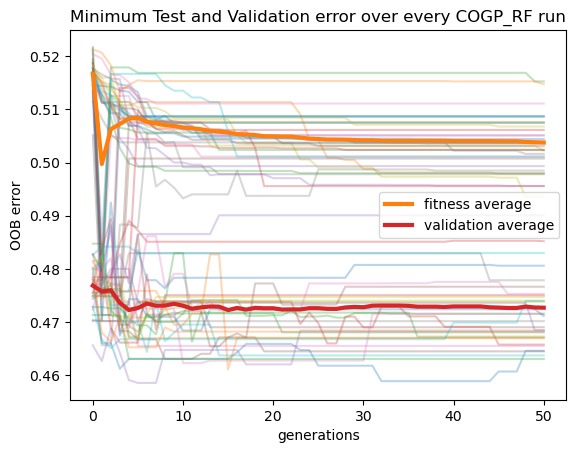

/tmp/ipykernel_92211/2270608402.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


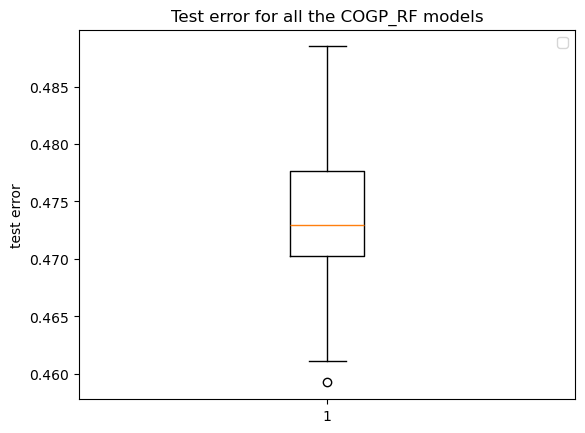

Avg test error: 0.4733655169873251 +- 0.006741238047416936
Min test error: 0.45925201582594305


In [6]:
plot_across_all_models(
    'simple_pred',
    (lambda i: i.log.select("fit_min"), "fitness"), (lambda i: i.log.select("val_min"), "validation"),
    title=f"Minimum Test and Validation error over every {best_run.model} run",
    x_axis="generations",
    y_axis="OOB error"
)
#plot_across_all_models('simple_pred', lambda i: i.log.select("val_min"), title="minimum validation error simple pred")
box_plot('simple_pred', (lambda i: i.test_error, "test error"), title=f"Test error for all the {best_run.model} models", y_axis="test error")

results = np.array(retrieve_from_files(lambda i: i.test_error, get_files("simple_pred")))
print("Avg test error:", f"{results.mean()} +- {results.std()}")
print("Min test error:", results.min())

In [7]:
def show(a_v_pairs: list[tuple[float, float]], title: str) -> None:
    aro, val = sum(a for a, _ in a_v_pairs) / len(a_v_pairs), sum(v for _, v in a_v_pairs) / len(a_v_pairs)
    plt.scatter([a for a, _ in a_v_pairs], [v for _, v in a_v_pairs],  s=20, color=(0.1, 0.1, 1, 0.7))
    plt.scatter([aro], [val], s=100, color=(1, 0, 0, 0.7))
    plt.xlabel("arousal")
    plt.ylabel("valence")
    plt.title(title)
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.show()


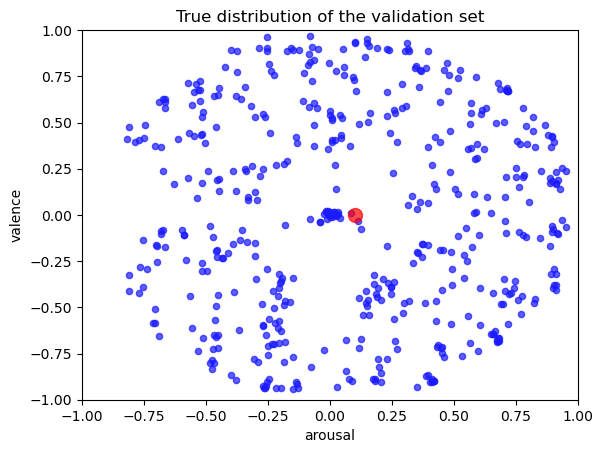

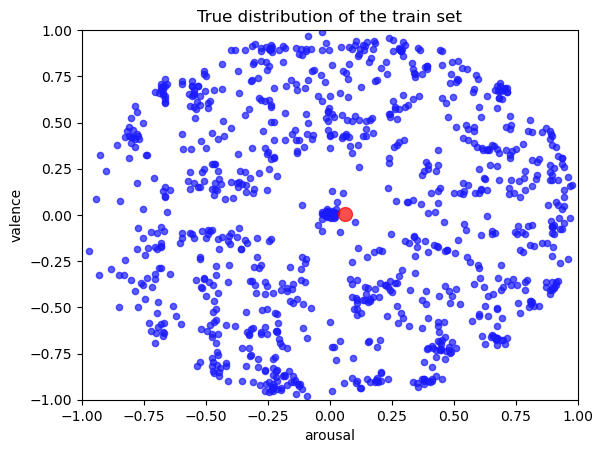

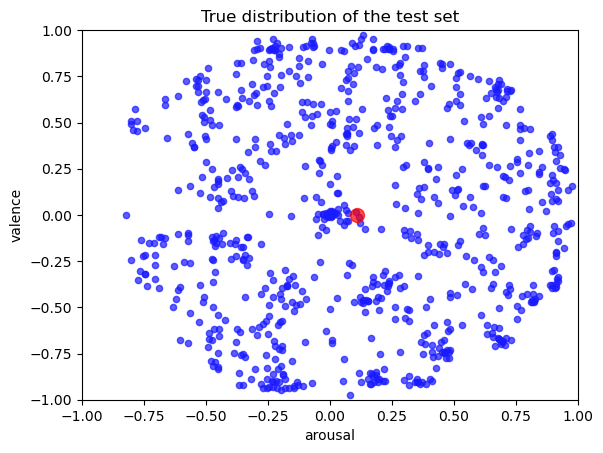

In [8]:
show(y_validation, title="True distribution of the validation set")
show(y_train, title="True distribution of the train set")
show(y_test, title="True distribution of the test set")

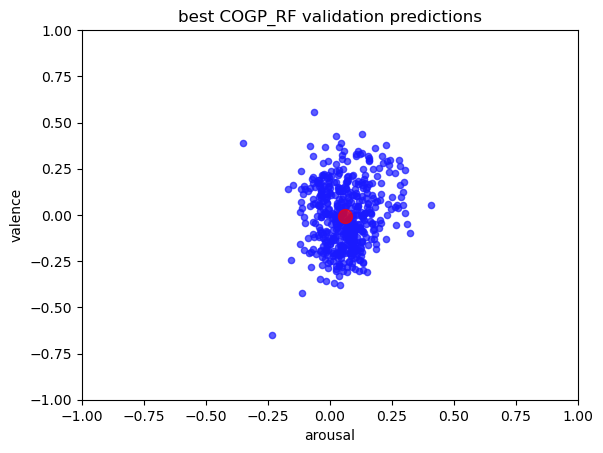

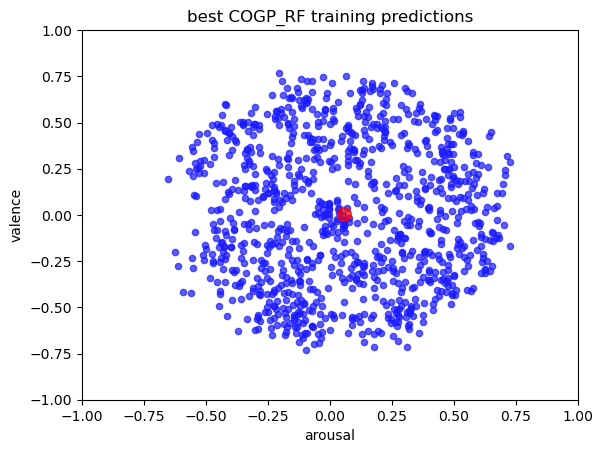

In [9]:
feature_extractor = toolbox.compile(best_individual)
val_features = np.array([feature_extractor(img) for img in x_validation])
train_features = np.array([feature_extractor(img) for img in x_train])
wrapper_model.fit(train_features, y_train)
val_predictions, train_predictions = wrapper_model.predict(val_features), wrapper_model.predict(train_features)
show(val_predictions, title=f"best {best_run.model} validation predictions")
show(train_predictions, title=f"best {best_run.model} training predictions")

'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'list' object has no attribute 'shape'
'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


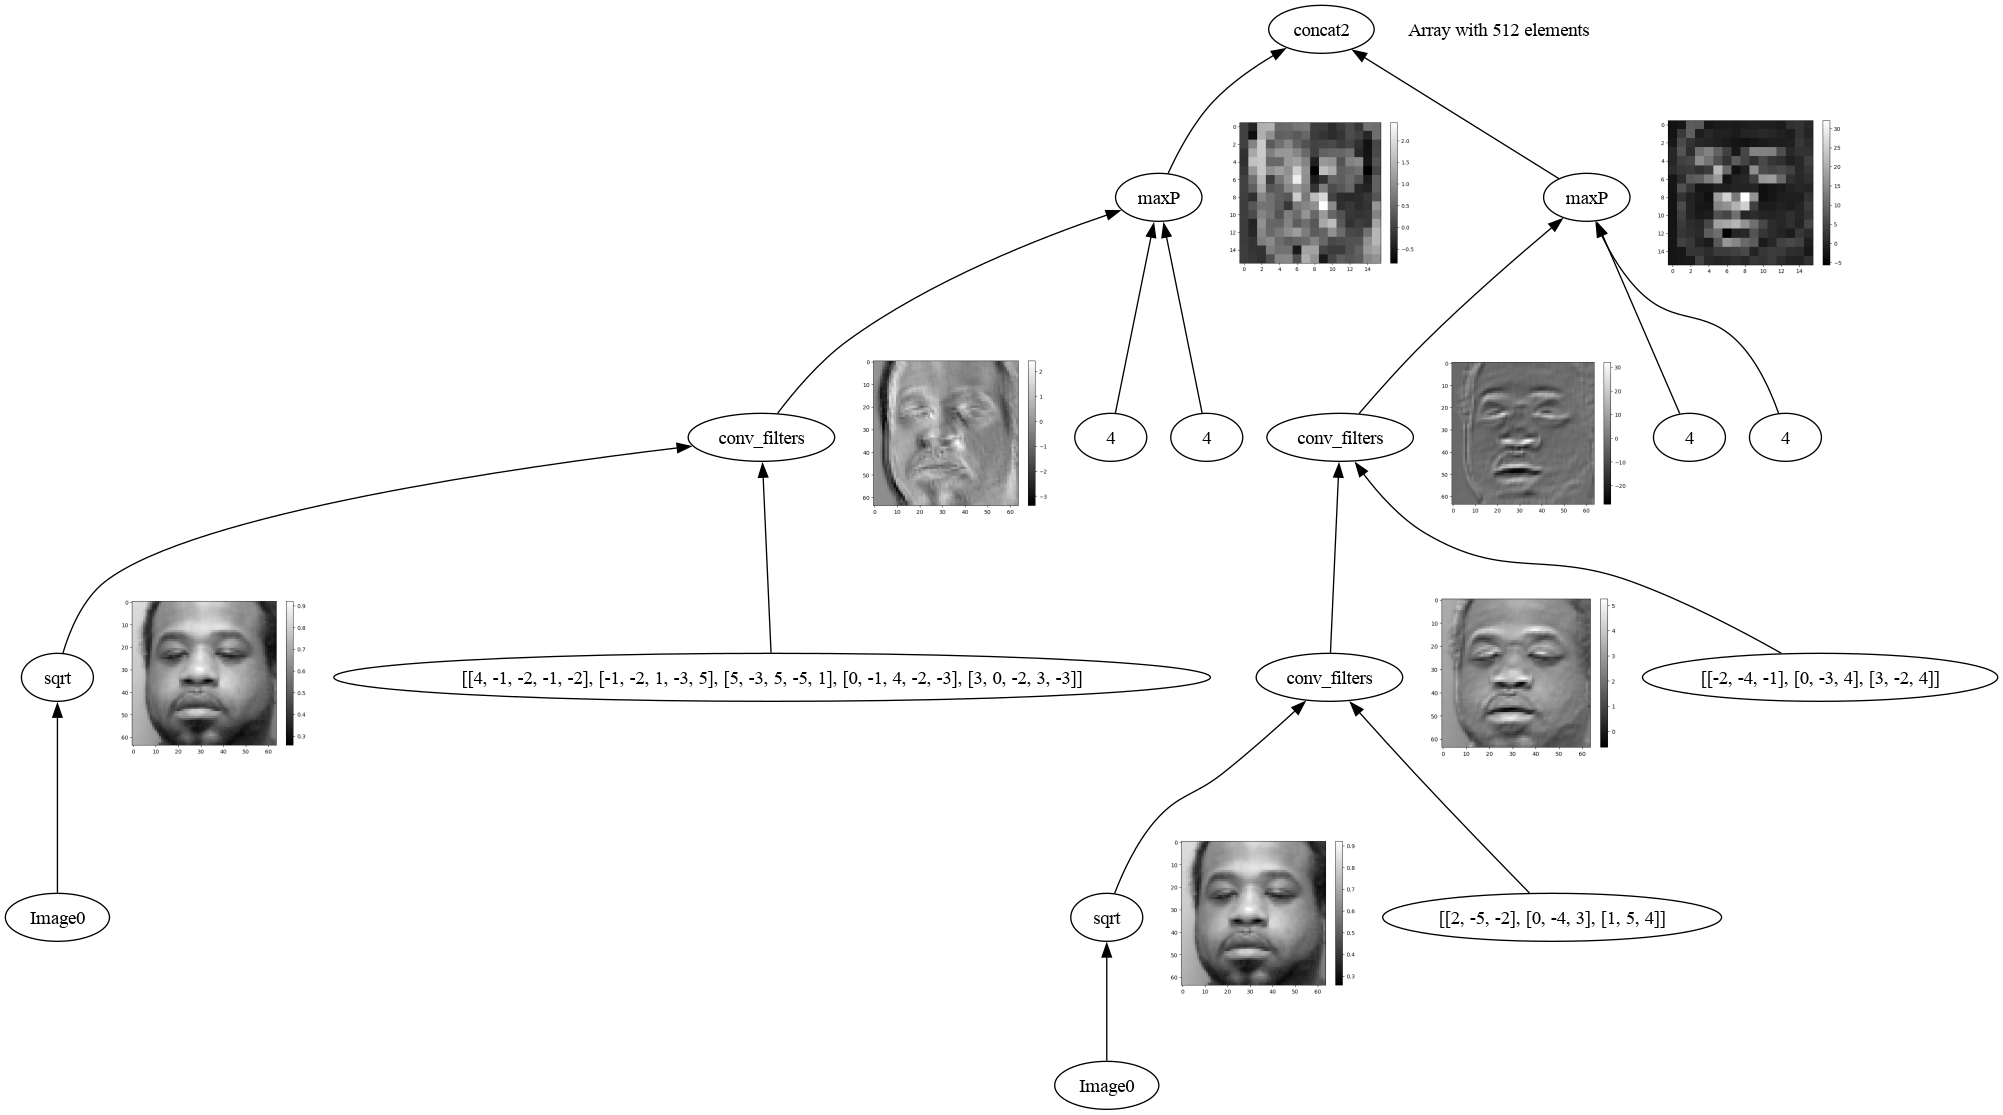

'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'list' object has no attribute 'shape'
'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


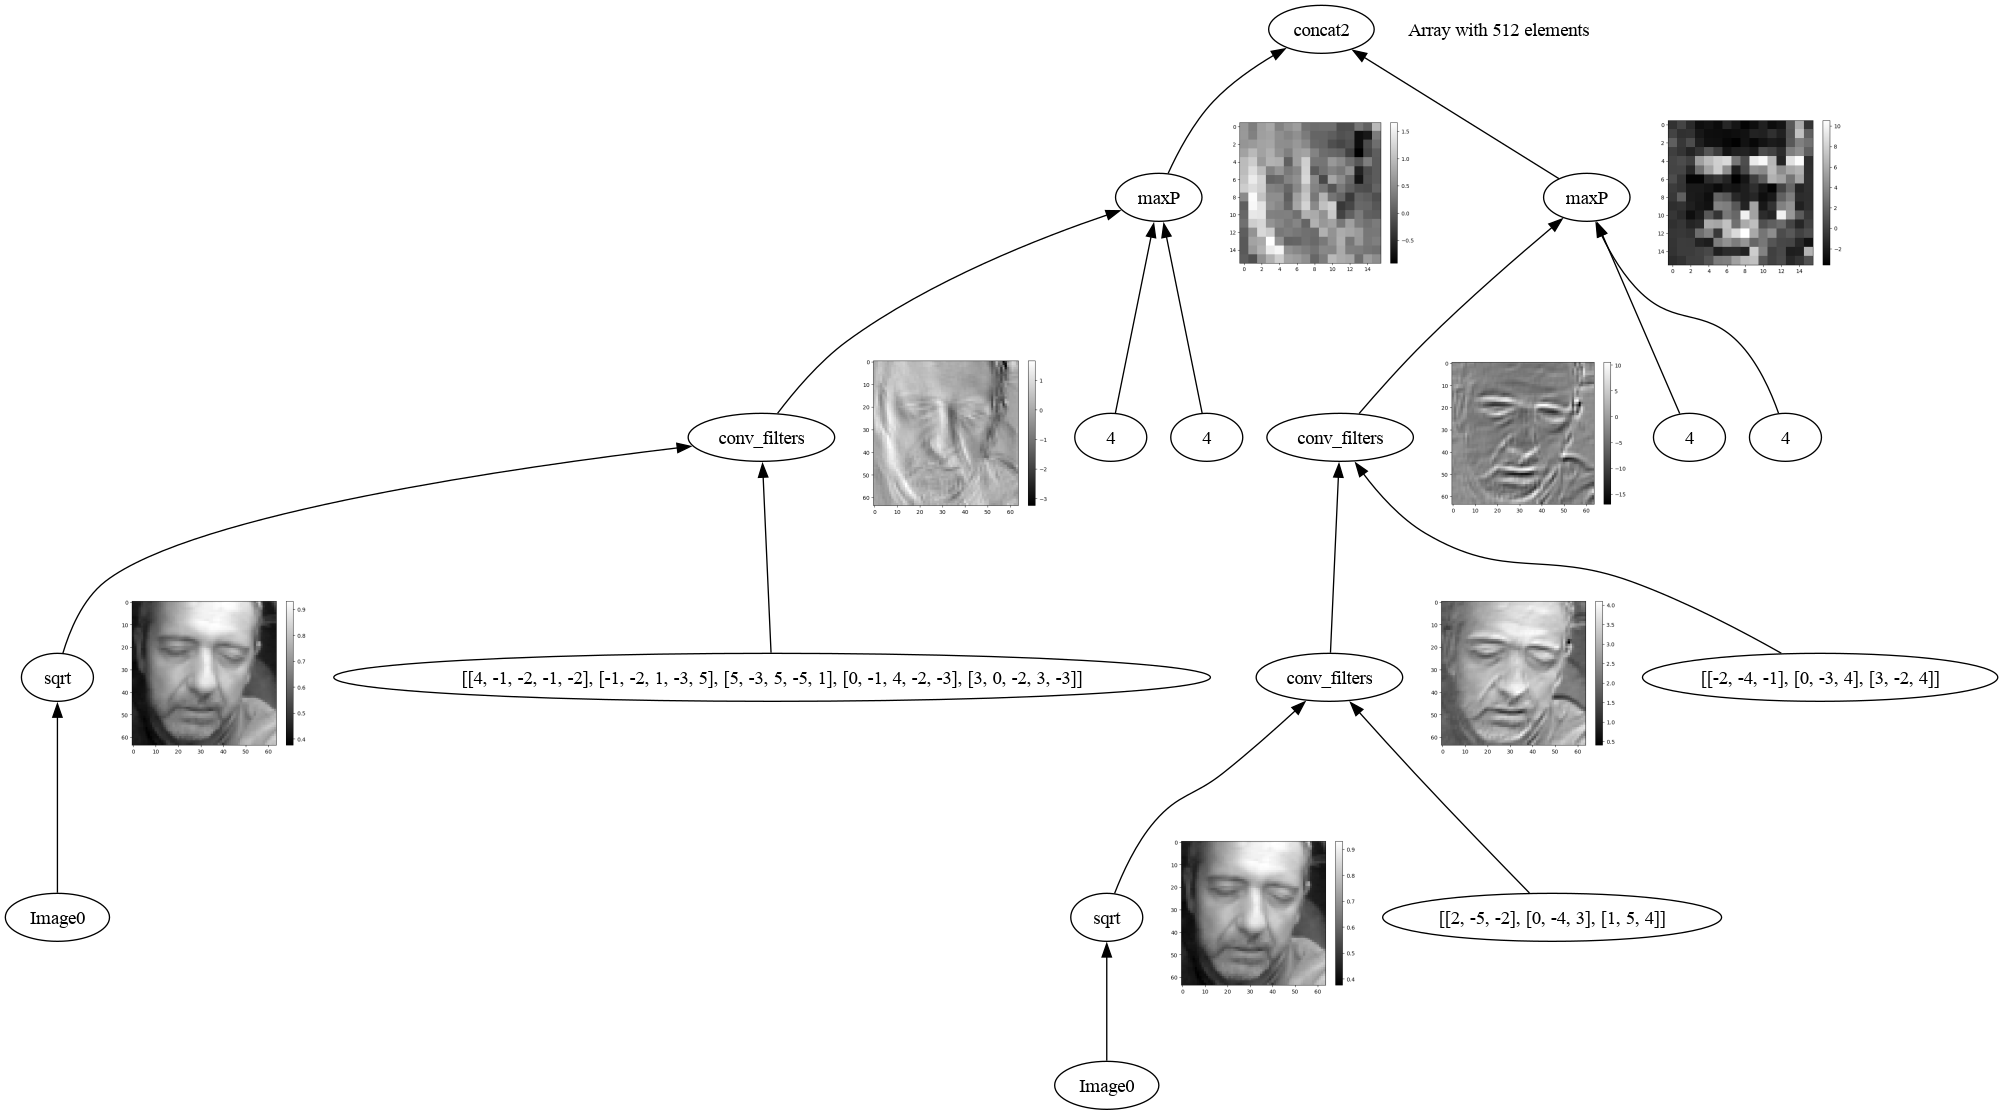

'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'list' object has no attribute 'shape'
'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


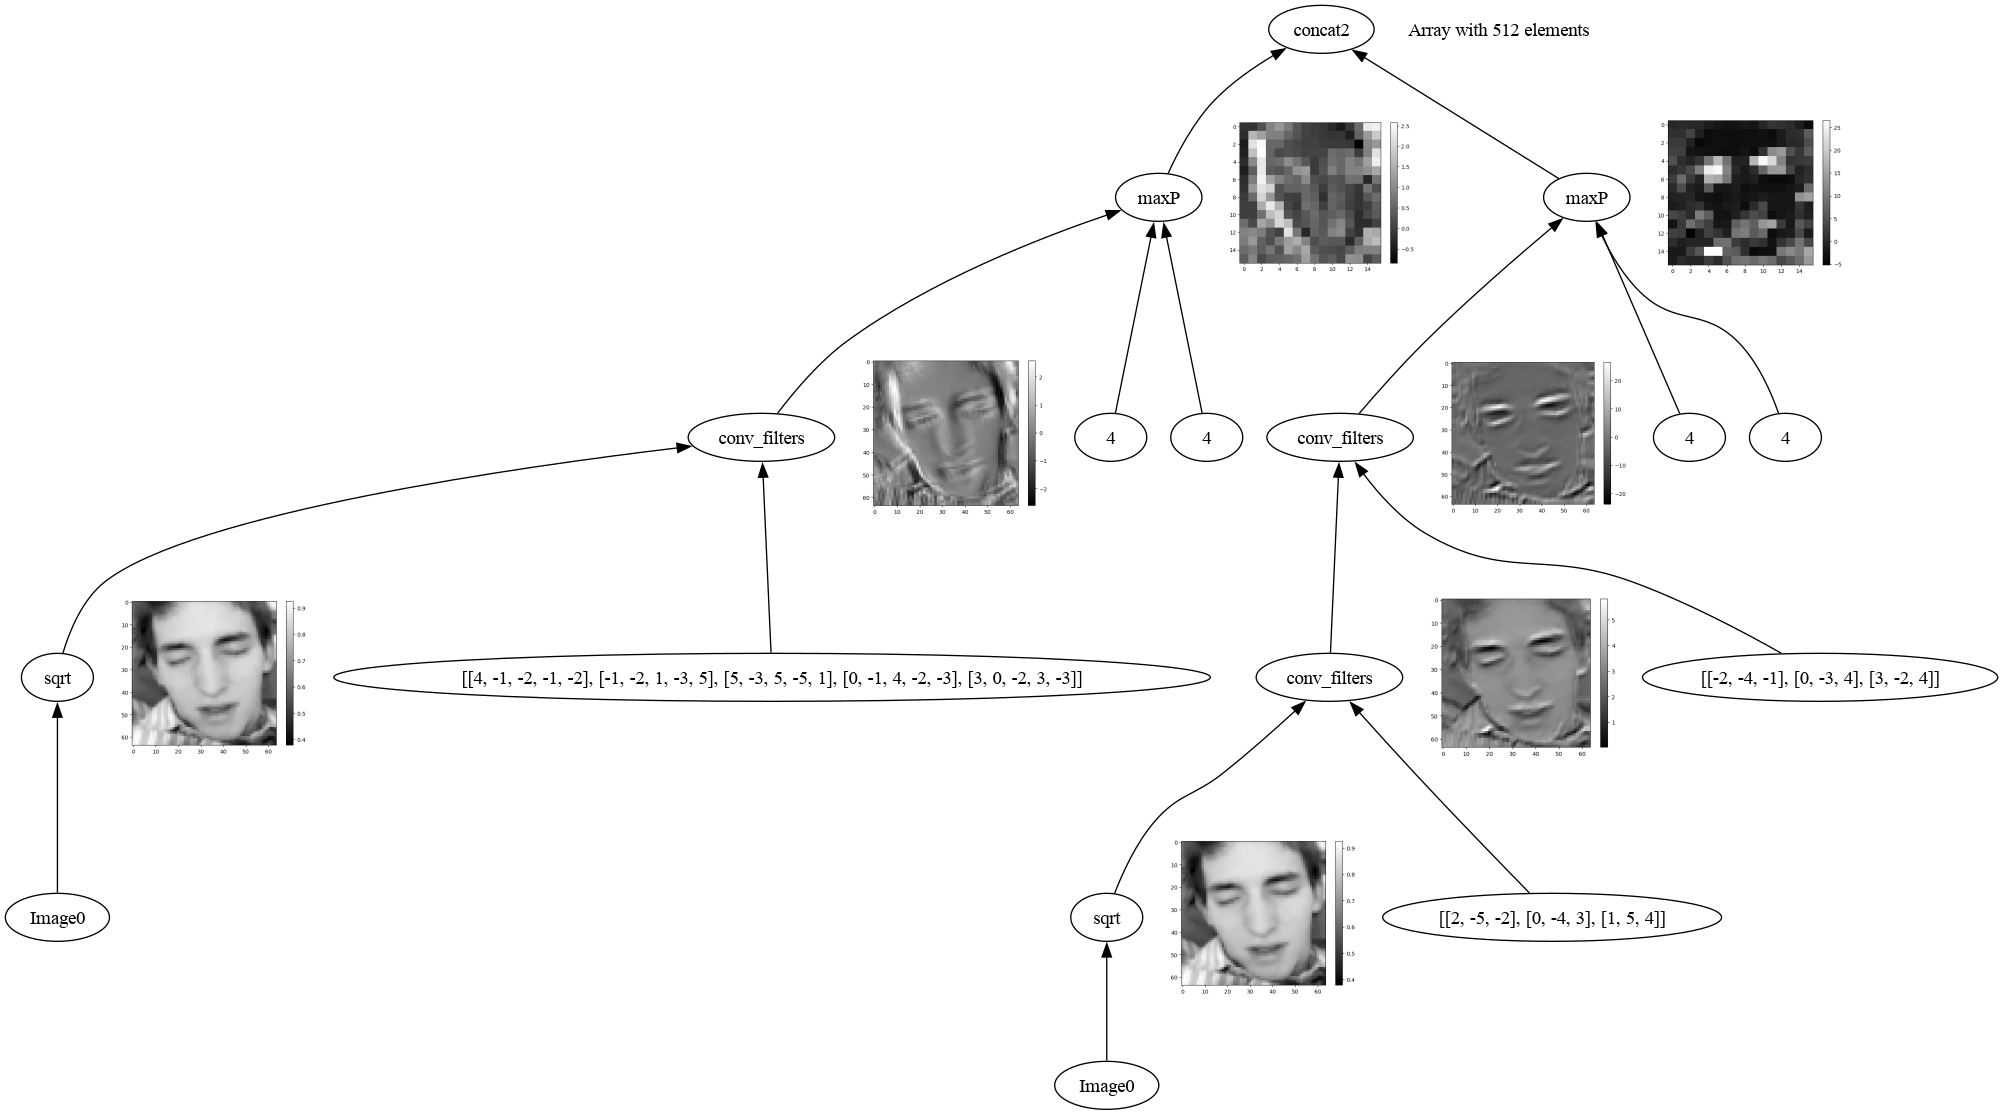

'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'list' object has no attribute 'shape'
'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


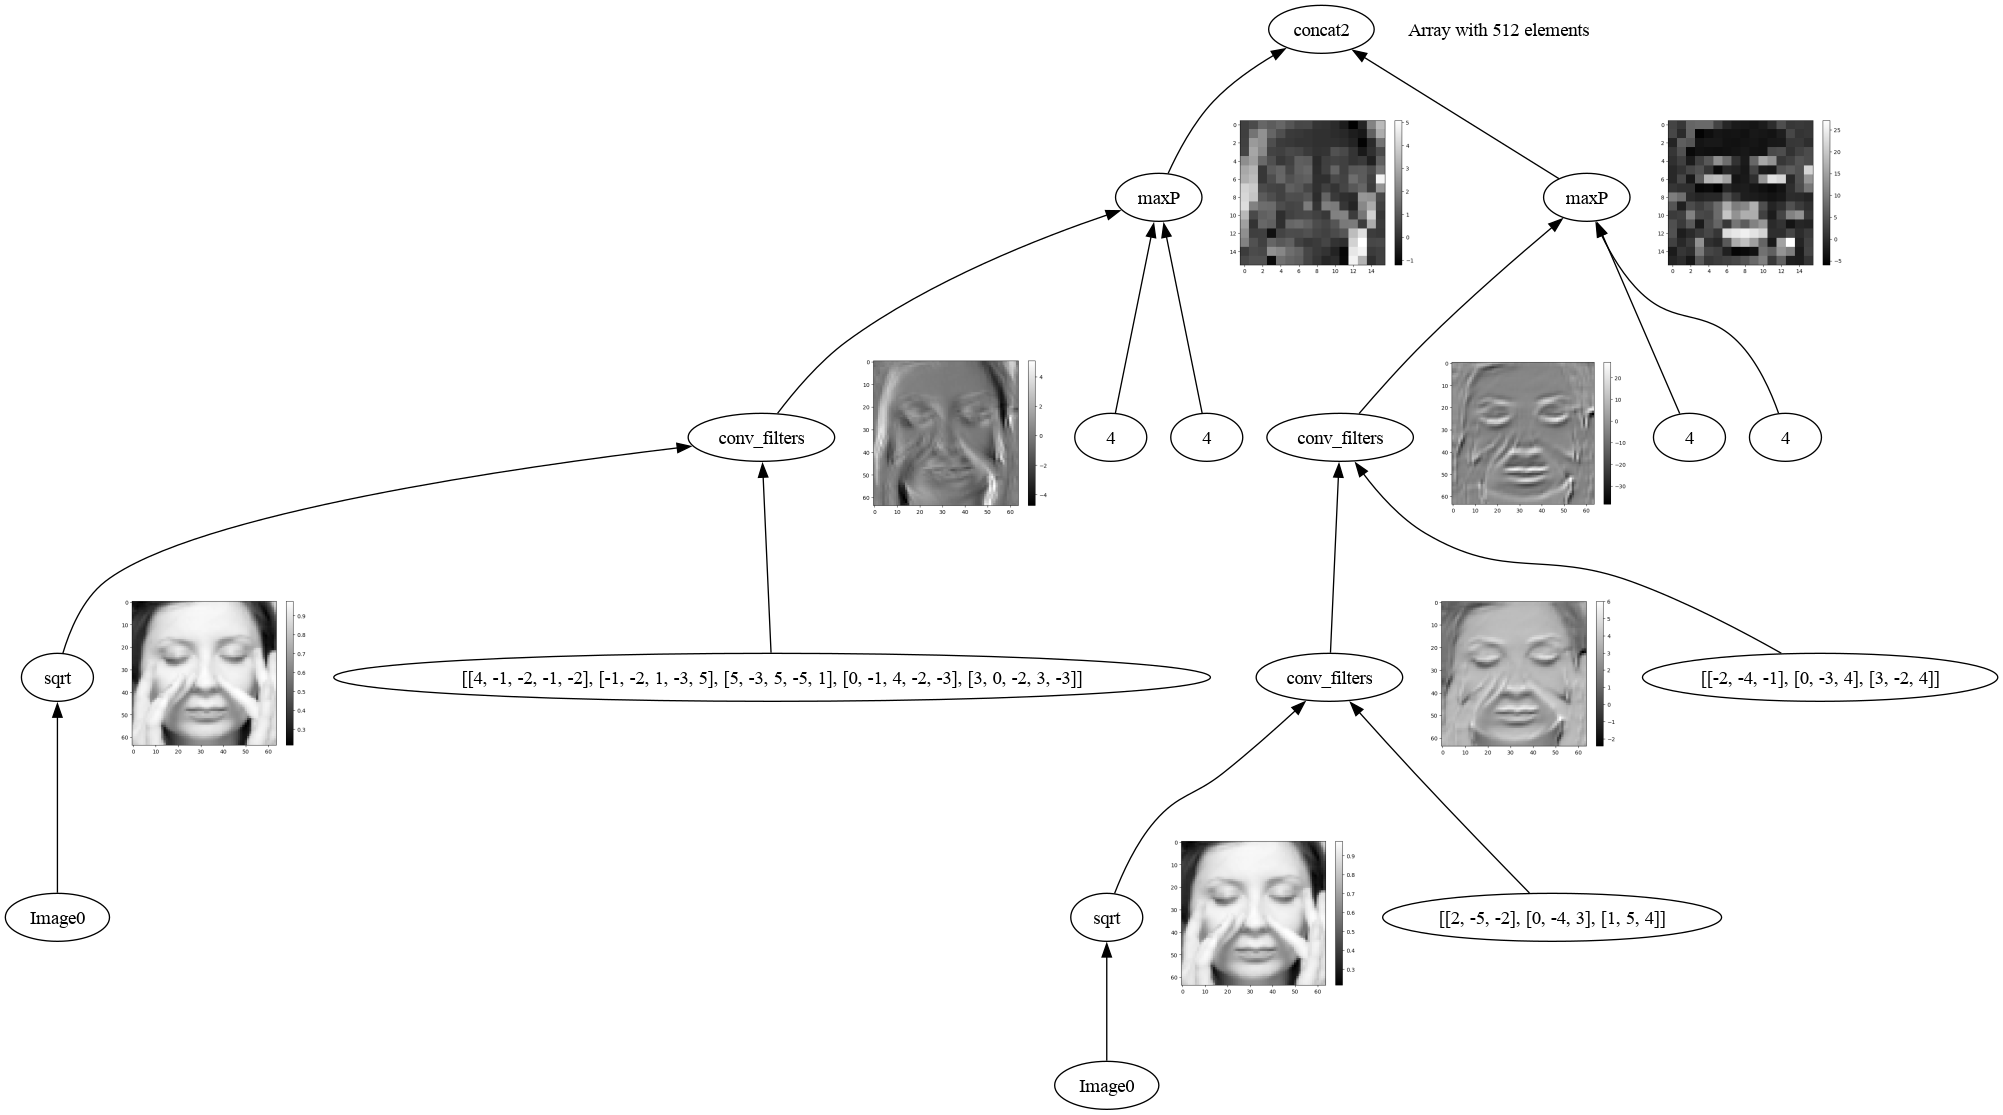

'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'list' object has no attribute 'shape'
'list' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


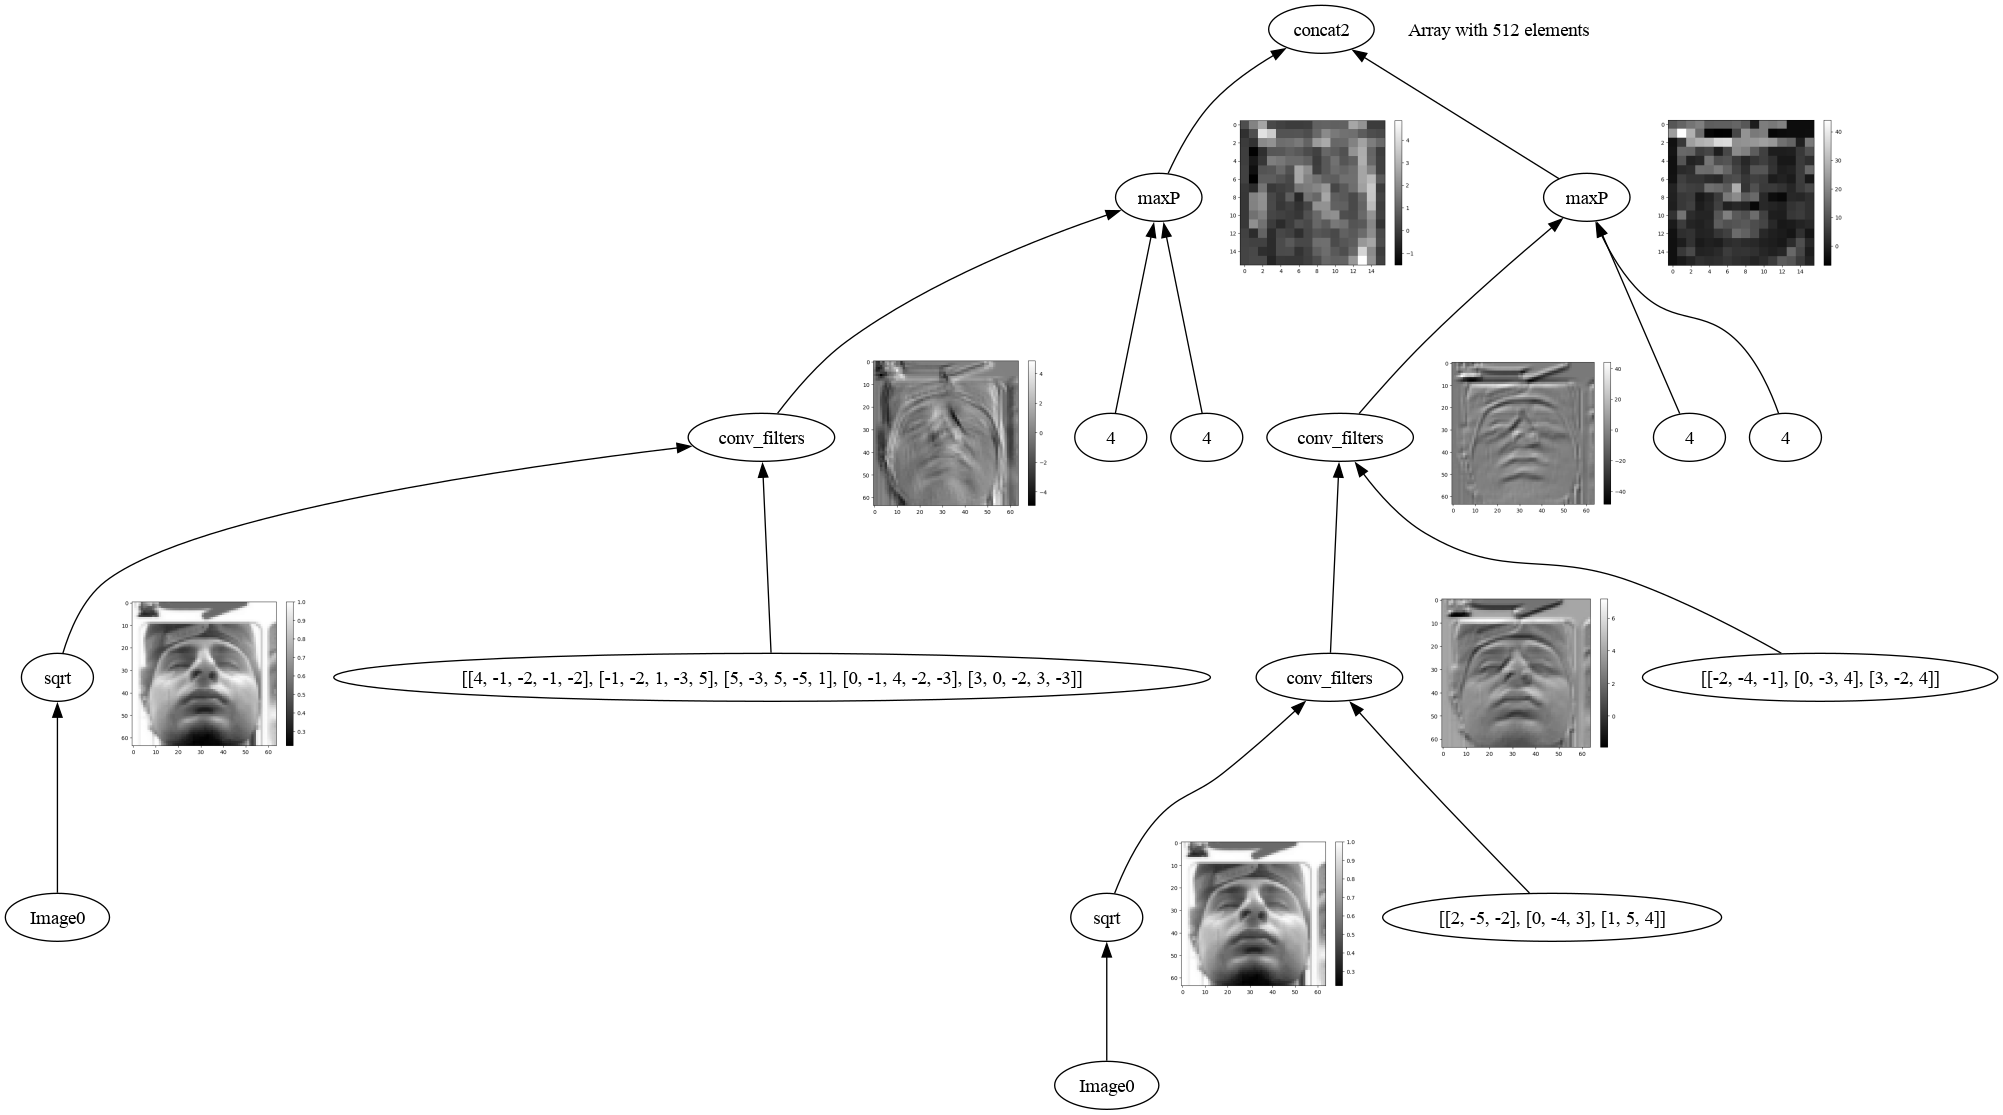

In [18]:
f = Tree.of(best_individual, pset)
for i, img in enumerate(x_train[:5]):
    TreeDrawer()\
    .register_draw_function(lambda t: len(t.value.shape) == 1,  lambda g, t: g.add_node(f"{t.id()}result", label=f"Array with {len(t.value)} elements", shape="plaintext"))\
    .save_graph(f"models/best_model{i}.png", f, img)
    display(Image(f"models/best_model{i}.png"))

In [ ]:
best_run = pickle.load(open('simple_pred/data/COGP_RF500-run_info.pkl', 'rb'))
best_individual = best_run.best_individual
wrapper_model = run_500.wrapper_model

In [9]:
f = Tree.of(best_500, pset)
for i, img in enumerate(x_train[:5]):
    TreeDrawer().register_draw_function(lambda t: len(t.value) > 5,  lambda g, t: g.add_node(f"{t.id()}result", label=f"Array with {len(t.value)} elements", shape="plaintext")).save_graph(f"models/best_model{i}.png", f, img)
    display(Image(f"models/best_model{i}.png"))

<IPython.core.display.Image object>

<IPython.core.display.Image object>

<IPython.core.display.Image object>

<IPython.core.display.Image object>

<IPython.core.display.Image object>

In [17]:
feature_extractor = toolbox.compile(best_500)
val_features = np.array([feature_extractor(img) for img in x_validation])
train_features = np.array([feature_extractor(img) for img in x_train])
wrapper_model.fit(train_features, y_train)
val_predictions, train_predictions = wrapper_model.predict(val_features), wrapper_model.predict(train_features)
show(val_predictions, title=f"best {best_run.model} validation predictions")
show(train_predictions, title=f"best {best_run.model} training predictions")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [18]:
param_grid = {
    'n_estimators': [50, 100, 120, 140, 150, 160, 200, 300, 400],
    'max_features': ["sqrt", 'log2', 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1],
    'max_depth': [1, 3, 5, 7, 9]
}

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [20]:
from shared_tools.fitness_function import model

In [21]:
def squared_distance(t1: tuple[float, float], t2: tuple[float, float]) -> float:
    return (t1[0] - t2[0])**2 + (t1[1] - t2[1])**2

def error(pred: Iterable[tuple[float, float]], truth: Iterable[tuple[float, float]]) -> float:
    errors = list(squared_distance(p, t) for p, t in zip(pred, truth))
    return sum(errors) / len(errors)


In [22]:
for n_estimators in [50, 100, 120, 140, 150, 160, 200, 300, 400]:
    predictor = model(n_estimators=n_estimators)
    predictor.fit(train_features, y_train)
    print("n estimators:", n_estimators, error(predictor.predict(val_features), y_validation), error(predictor.predict(train_features), y_train))


n estimators: 50 0.4596257683413776 0.07332823469157063
n estimators: 100 0.45859826148336585 0.07011469955764775
n estimators: 120 0.4578672347669765 0.0696435663753231
n estimators: 140 0.45951553650316906 0.06929959243087865
n estimators: 150 0.4590739712328209 0.06901076542566142
n estimators: 160 0.458748439922011 0.06886368523604233
n estimators: 200 0.4581368456266677 0.0682490936612806
n estimators: 300 0.4571840027983487 0.06792975020541407
n estimators: 400 0.45651303586211955 0.06762356421959646


In [22]:
for max_features in ["sqrt", 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]:
    predictor = model(max_features=max_features)
    predictor.fit(train_features, y_train)
    print("max_features", max_features, error(predictor.predict(val_features), y_validation), error(predictor.predict(train_features), y_train))



max_features sqrt 0.47258347377736215 0.0703651462595454
max_features log2 0.48256995831661764 0.07194591104289749
max_features 0.1 0.467776782237187 0.07046030619545318
max_features 0.2 0.46991420305822035 0.07009193890390536
max_features 0.3 0.4683847470381259 0.06995287244599893
max_features 0.4 0.460810635380418 0.07039460518887447
max_features 0.5 0.46514810310749705 0.07020465231995966
max_features 0.7 0.46284042032243855 0.0701771027110667
max_features 0.9 0.46042586902684124 0.07137041051644322
max_features 1.0 0.45859826148336585 0.07011469955764775


In [20]:
for max_depth in [1, 3, 5, 7, 9, 11, 13]:
    predictor = model(max_depth=max_depth)
    predictor.fit(train_features, y_train)
    print("max_depth", max_depth, error(predictor.predict(val_features), y_validation), error(predictor.predict(train_features), y_train))



max_depth 1 0.49846707796357387 0.518012955548124
max_depth 3 0.4718771228882962 0.44986576015117485
max_depth 5 0.4631200868214518 0.3375663196870877
max_depth 7 0.4633798156570781 0.21882472080164808
max_depth 9 0.4606657602317625 0.13523158493365314
max_depth 11 0.45959881910156264 0.09402501992941108
max_depth 13 0.4574404734603596 0.07741434677643298


In [ ]:
for max_depth